In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

In [7]:
H = W = 30
B=H*W

ray_origins = t.tensor([-5.0, 0, 0]).reshape([1, 3]).expand([B, 3])

x_dirs = t.linspace(-0.3, 0.3, W).unsqueeze(0).expand([H, W]).reshape([-1])
y_dirs = t.linspace(-0.3, 0.3, H).unsqueeze(1).expand([H, W]).reshape([-1])

# todo: we should normalize these
ray_directions = t.stack([t.ones(B), x_dirs, y_dirs], dim=1)
print(ray_directions)


tensor([[ 1.0000, -0.3000, -0.3000],
        [ 1.0000, -0.2793, -0.3000],
        [ 1.0000, -0.2586, -0.3000],
        ...,
        [ 1.0000,  0.2586,  0.3000],
        [ 1.0000,  0.2793,  0.3000],
        [ 1.0000,  0.3000,  0.3000]])


## Step 1: render a single triangle

In [4]:
vertices = t.tensor([[[3.0, 0, 0], [3, 0, 1], [3, 1, 1]]]).expand([B, 3, 3])

vertex_0 = vertices[:, 0]
vertex_1 = vertices[:, 1]
vertex_2 = vertices[:, 2]

edge_1 = vertex_1 - vertex_0

edge_2 = vertex_2 - vertex_0

h = ray_directions.cross(edge_2, dim=1)

a = t.einsum("bx,bx->b", edge_1, h)

EPSILON = 1e-7

mask = (a > -EPSILON) & (a < EPSILON)

f = 1.0 / a
s = ray_origins - vertex_0
u = f * t.einsum("bx,bx->b", s, h)

mask2 = (u < 0) | (u > 1)

q = s.cross(edge_1, dim=1)
v = f * t.einsum("bx,bx->b", ray_directions, q)
mask3 = (v < 0) | (u + v > 1)


torch.Size([900, 3, 3])


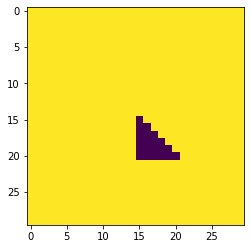

In [5]:
plt.imshow((mask | mask2 | mask3).reshape([H, W]))


## Step 2: render multiple triangles


In [6]:
from stl import mesh


In [7]:
mesh.Mesh.from_file("pikachu_1gen_flowalistik.STL").vectors.shape


(412, 3, 3)

In [8]:
# https://www.thingiverse.com/thing:376601
model = mesh.Mesh.from_file("pikachu_1gen_flowalistik.STL")
model.translate(np.array([0, 0, -30]))
# model = mesh.Mesh.from_file('utahteapot.stl')
# teapot.translate(np.array([20, 0, -4]))


In [10]:
vertices = t.tensor(model.vectors.copy())


In [11]:
vertex_0 = vertices[:, 0].unsqueeze(0)
vertex_1 = vertices[:, 1].unsqueeze(0)
vertex_2 = vertices[:, 2].unsqueeze(0)


In [12]:
H = W = 300
B = H * W

ray_origins = t.tensor([-150.0, -50, 50]).reshape([1, 3]).expand([B, 3])

x_dirs = t.linspace(0.15, 0.65, W).unsqueeze(0).expand([H, W]).reshape([-1])

y_dirs = t.linspace(-0.6, -0.1, H).unsqueeze(1).expand([H, W]).reshape([-1])

ray_directions = t.stack([t.ones(B), x_dirs, y_dirs], dim=1)


In [13]:
num_vertices = vertices.shape[0]


In [44]:
%%time
edge_1 = vertex_1 - vertex_0
edge_2 = vertex_2 - vertex_0

h = ray_directions.unsqueeze(1).expand([B, num_vertices, 3]).cross(edge_2.expand([B, num_vertices, 3]), dim=2)

a = t.einsum('bvx,bvx->bv', edge_1, h)

EPSILON = 1e-7

mask = (a > -EPSILON) & (a < EPSILON)

f = 1. / a
s = ray_origins.unsqueeze(1) - vertex_0
u = f * t.einsum('bvx,bvx->bv', s, h)

mask2 = (u < 0) | (u > 1)

q = s.cross(edge_1.expand([B, num_vertices, 3]), dim=2)
v = f * t.einsum('bx,bvx->bv', ray_directions, q)
mask3 = (v < 0) | (u + v > 1)

CPU times: user 9.19 s, sys: 1.07 s, total: 10.3 s
Wall time: 2.59 s


In [45]:
mask2.shape


torch.Size([90000, 412])

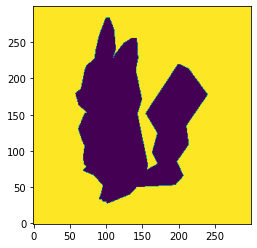

In [46]:
pixel_mask = (mask2 | mask3).all(dim=1)
plt.imshow(pixel_mask.reshape([H, W]), origin="lower")


In [18]:
# this variable is called `t` in the wikipedia C++ code
t_ = f * t.einsum("zvd,pvd->pv", edge_2, q)


In [19]:
t_.shape


torch.Size([90000, 412])

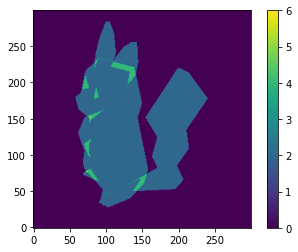

In [20]:
# this shows how many triangles every ray hits
plt.imshow((~mask2 & ~mask3).sum(dim=1).reshape([H, W]), origin="lower")
plt.colorbar()


In [21]:
intersection_points = t.einsum(
    "pv,pd->pvd", t_, ray_directions
) + ray_origins.unsqueeze(1)


In [22]:
intersection_points.shape


torch.Size([90000, 412, 3])

In [23]:
pixel_vertex_mask = mask2 | mask3


In [24]:
pixel_vertex_mask.shape


torch.Size([90000, 412])

In [25]:
import numpy as np


In [26]:
t_[pixel_vertex_mask] = float("inf")


In [27]:
selected_triangle_ids = t_.argmin(dim=1)


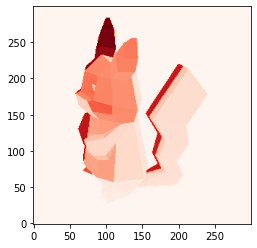

In [28]:
plt.imshow(selected_triangle_ids.reshape([H, W]), origin="lower", cmap="Reds")


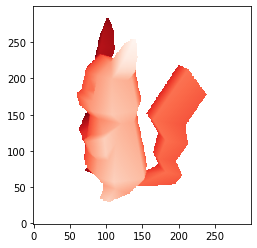

In [29]:
plt.imshow(t_.min(dim=1).values.reshape([H, W]), origin="lower", cmap="Reds")


In [30]:
selected_t = t.gather(t_, dim=1, index=selected_triangle_ids.unsqueeze(1)).squeeze(1)


In [31]:
triangle_ids_2d = selected_triangle_ids.reshape([H, W])


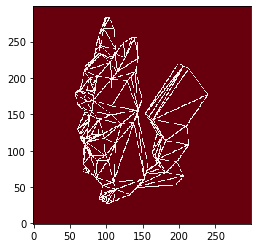

In [32]:
plt.imshow(
    (triangle_ids_2d[1:, 1:] == triangle_ids_2d[:-1, 1:])
    & (triangle_ids_2d[1:, 1:] == triangle_ids_2d[1:, :-1]),
    origin="lower",
    cmap="Reds",
    interpolation="nearest",
)


In [33]:
selected_vertices = t.gather(
    vertices, 0, selected_triangle_ids.reshape([-1, 1, 1]).expand([-1, 3, 3])
)


In [34]:
selected_vertices.shape


torch.Size([90000, 3, 3])

In [35]:
model.normals.shape


(412, 3)

In [36]:
normals = t.tensor(model.normals.copy())


In [37]:
relevant_normals = t.gather(
    normals, 0, selected_triangle_ids.reshape([-1, 1]).expand([-1, 3])
)


In [38]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [39]:
def foo(x=1.0, y=0.0, z=0.0):
    total = (x ** 2 + y ** 2 + z ** 2) ** 0.5
    vec = t.tensor([x, y, z]) / total
    plt.imshow(
        (
            (
                t.max(
                    (relevant_normals * vec).sum(dim=1) / relevant_normals.norm(dim=1),
                    t.tensor(0.0),
                )
                * ~pixel_mask
            )
        ).reshape([H, W]),
        origin="lower",
        cmap="Reds",
    )
    plt.colorbar()


In [40]:
relevant_normals.shape


torch.Size([90000, 3])

In [41]:
interact(foo)


interactive(children=(FloatSlider(value=1.0, description='x', max=3.0, min=-1.0), FloatSlider(value=0.0, descr…

<function __main__.foo(x=1.0, y=0.0, z=0.0)>

In [42]:
1 + 2


3

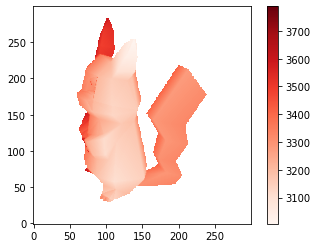

In [43]:
plt.imshow(
    (
        (
            (
                t.max(relevant_normals[:, 0]) / relevant_normals.norm(dim=1)
                + 200
                + t_.min(dim=1).values * 20
            )
        )
        * (~mask2 & ~mask3).any(dim=1)
    ).reshape([H, W]),
    origin="lower",
    cmap="Reds",
)
plt.colorbar()
